# Trabajo de Final de Máster

- Entrega: 2
- Fecha: 29/10/2021
- Autores: Mario Mérida, Jesus García Solsana, Eduerdo Farías Pedreros

# Carga de librerias

In [1]:
# para preparacion de datos
import numpy as np
import pandas as pd

# para trabajar con archivos en explorador
import os

# para cargar metadatos de archivos dicom 
import csv

# para procesamiento de imagenes
import cv2
from PIL import Image

# para leer imagenes
import pydicom as dicom
import matplotlib.pylab as plt

# para division train_test_split
from sklearn.model_selection import train_test_split

# para modelado
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img # para convertir imagenes en matrices
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model # para realizar modelop en base a dataframe
from keras.layers import Conv2D, MaxPooling2D 
from keras import regularizers, optimizers
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization # para layers de modelo

# Preparacion de imagenes

## Imagen `dicom`

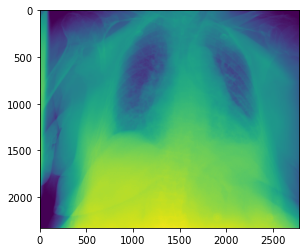

In [2]:
# ruta a carpeta con imagen DCM
ex_img_dcm_dir = "./data/train/00086460a852/9e8302230c91/"

# imagen DCM a testear
ex_img_dcm_file = '65761e66de9f.dcm'

# direccion completa a imagen DCM a testear
ex_img_dcm_full_dir = os.path.join(ex_img_dcm_dir, ex_img_dcm_file)

# cargamos la imagen
ex_img_dcm = dicom.dcmread(ex_img_dcm_full_dir)

# muestra de resultados
plt.imshow(ex_img_dcm.pixel_array)

In [3]:
print("Tipo de imagen:", type(ex_img_dcm))
print("Dimensiones de matrix de imagen:", img_to_array(ex_img_dcm.pixel_array).shape)

Tipo de imagen: <class 'pydicom.dataset.FileDataset'>
Dimensiones de matrix de imagen: (2330, 2783, 1)


## Conversion de `dcm` a `jpg`

File saved successfully


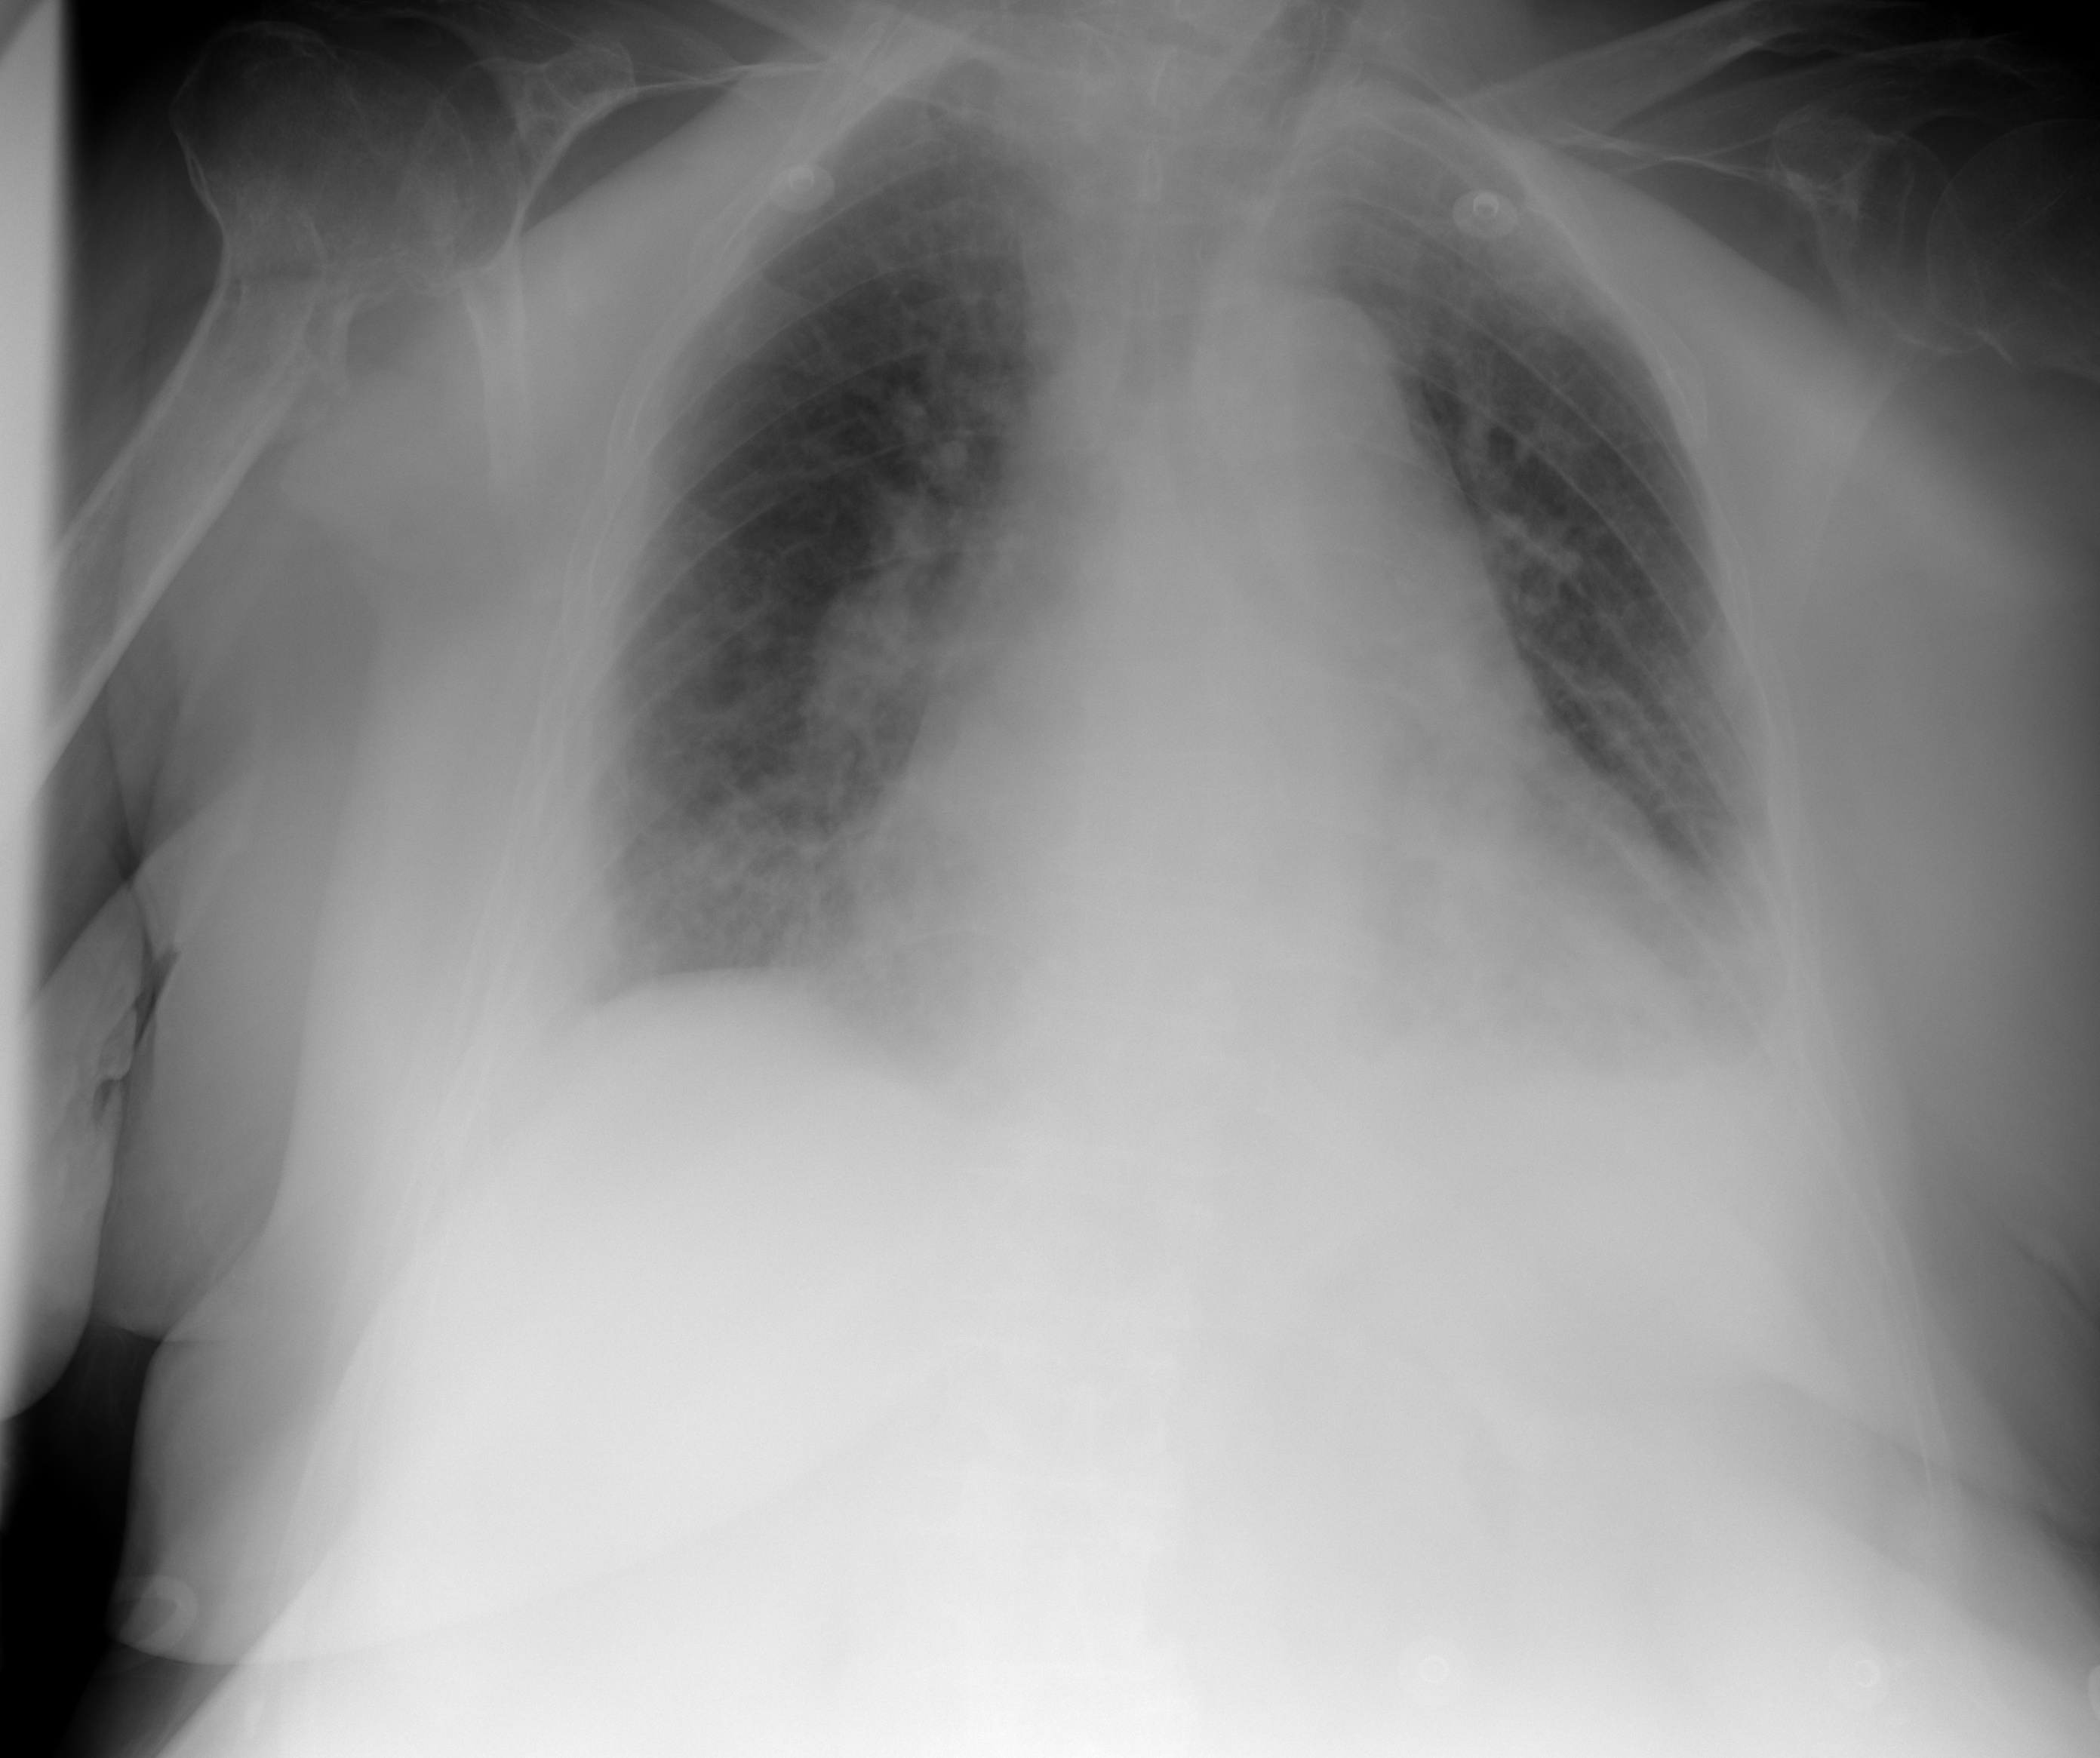

In [4]:
# matriz de pixeles para imagen DCM
ex_dcm_pixel_array_numpy = ex_img_dcm.pixel_array

# normalizado de escala de imagen (de int16 a uint8)
ex_scaled_img = cv2.convertScaleAbs(ex_dcm_pixel_array_numpy-np.min(ex_dcm_pixel_array_numpy), alpha=(255.0 / min(np.max(ex_dcm_pixel_array_numpy)-np.min(ex_dcm_pixel_array_numpy), 10000)))

# definimos ubicacion de archivo JPG
ex_img_jpg_dir = "./data/examples/train_jpg/"

# creamos carpeta si no existe
if not os.path.exists(ex_img_jpg_dir):
    os.makedirs(ex_img_jpg_dir)

# remplazo extenision DCM a JPG
ex_img_jpg_file = ex_img_dcm_file.replace('.dcm', '.jpg')

# direccion completa a imagen JPG a testear
ex_img_jpg_full_dir = os.path.join(ex_img_jpg_dir, ex_img_jpg_file)

# creamos archivo JPG en directorio dado
result = cv2.imwrite(ex_img_jpg_full_dir, ex_scaled_img)
if result==True:
    print('File saved successfully')
else:
    print('Error in saving file')

# mostramos imagen
ex_img_jpg = load_img(ex_img_jpg_full_dir)
ex_img_jpg

### Características de imagen `jpg`

In [5]:
print("Tipo de imagen:", type(ex_img_jpg))
print("Modo de imagen:", ex_img_jpg.mode)
print("Tamaño de imagen:", ex_img_jpg.size)
print("Dimensiones de matrix de imagen:", img_to_array(ex_img_jpg).shape)

Tipo de imagen: <class 'PIL.Image.Image'>
Modo de imagen: RGB
Tamaño de imagen: (2783, 2330)
Dimensiones de matrix de imagen: (2330, 2783, 3)


### Cambio de imagen `jpg` a escala de grises y reducida

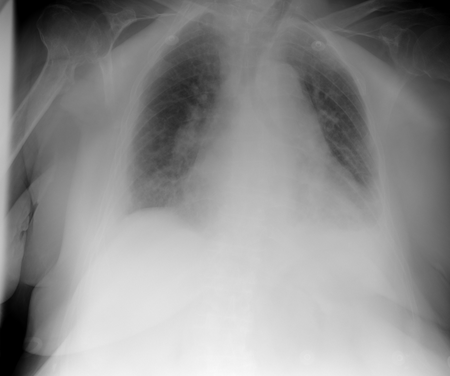

In [6]:
# definimos el ancho de la imagen escalada en pixeles
basewidth = 450

#abrimos la imagen y la pasamos a escala de grises
ex_img_jpg_red = Image.open(ex_img_jpg_full_dir).convert('L')

# calculamos relacion entre imagen original y nueva imagen
wpercent = (basewidth / float(ex_img_jpg.size[0]))

#ajustamos el alto de la imagen
hsize = int((float(ex_img_jpg.size[1]) * float(wpercent)))

# cambiamos el tamaño de la imagen en base al ancho dado y alto calculado
ex_img_jpg_red = ex_img_jpg.resize((basewidth, hsize), Image.ANTIALIAS)

# agergamos subfijo para identificar reduccion de calidad
ex_img_jpg_red_full_dir = ex_img_jpg_full_dir.replace('.jpg', '_red.jpg')

# guardamos la imagen
ex_img_jpg_red.save(ex_img_jpg_red_full_dir)

# mostramos la imagen jpg
ex_img_jpg_red

In [7]:
print("Tipo de imagen:", type(ex_img_jpg_red))
print("Modo de imagen:", ex_img_jpg_red.mode)
print("Tamaño de imagen:", ex_img_jpg_red.size)
print("Dimensiones de matrix de imagen:", img_to_array(ex_img_jpg_red).shape)

Tipo de imagen: <class 'PIL.Image.Image'>
Modo de imagen: RGB
Tamaño de imagen: (450, 376)
Dimensiones de matrix de imagen: (376, 450, 3)


### Conclusion de imágenes

Por medio de la librería `pydicom`, las imgenes pueden leerse direcamente como fueron obtenidas de la fuente en formato `DCM` en Python. Sin embargo la resolución de las imágenes y la gama de colores pueden tener un coste computacional considerables al momento de analizar grandes volúmenes de datos.

Se decidió convertir el formato de la imágen a `JPG` donde se observa que la gamma de colores se reduce naturalmente a escala de grises. Esto tiene sentido ya que las radiografías suelen estar en una gama de colores entre azul y negro. También analizamos la posibilidad de escalar la imágen para reducir el coste computacional a expensas de la precisión de un modelo.

# Preparacion de dataframes

## Dataframe `train_study_level.csv`

In [8]:
# directorio de datos de entrenamiento
train_dir = "./data/train/"

# cargamos datos de estudio
df_train_study = pd.read_csv('./train_study_level.csv')

# limpiamos datos a relacionar
df_train_study['study_dir'] = df_train_study['id'].str.replace('_study','')

# quitamos columnas redundantes
df_train_study = df_train_study.drop(columns = ['id'])

# muestra resultados
df_train_study.head()

Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
0                       0                   1                         0   
1                       0                   0                         0   
2                       1                   0                         0   
3                       1                   0                         0   
4                       0                   0                         0   

   Atypical Appearance     study_dir  
0                    0  00086460a852  
1                    1  000c9c05fd14  
2                    0  00292f8c37bd  
3                    0  005057b3f880  
4                    1  0051d9b12e72

## Dataframe `train_image_level.csv`

In [9]:
# cargamos datos de imagenes
df_train_image = pd.read_csv('./train_image_level.csv')

#limpiamos los datos
df_train_image["image_name"] = df_train_image["id"].str.replace('_image', '')

#quitamos datos redundantes
df_train_image = df_train_image.drop(columns = {'id'})

# muestra resultados
df_train_image.head()

boxes  \
0  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1                                                NaN   
2  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   

     image_name  
0  000a312787f2  
1  000c3a3f293f  
2  0012ff7358bc  
3  001398f4ff4f  
4  001bd15d1891

## Dataframe de contentido en `carpeta train`

In [10]:
# creacion de lista auxiliar
train_walk_list = []

# carga de datos de carpetas, subcarpetas y archivos de un dado directorio
for root, directories, files in os.walk(train_dir, topdown=False):
	for name in files:
		train_walk_list.append(os.path.join(root, name))

# creacion de un dataframe con los datos obtenidos
df_train = pd.DataFrame(train_walk_list)

# separacion de datos en columnas
df_train[0] = df_train[0].str.replace('\\', '/', regex=True)
df_train[['data','root','train_dir', 'study_dir','study_subdir', 'image_name']] = df_train[0].str.split('/', expand=True)
df_train[['image_name', 'ext']] = df_train['image_name'].str.split('.',expand=True)
df_train['full_dir'] = df_train[0]

# quitamos columnas redundantes
df_train = df_train.drop(columns = [0, 'data', 'root', 'train_dir', 'ext'])

# mostrar resultados
df_train.head()

study_dir  study_subdir    image_name  \
0  00086460a852  9e8302230c91  65761e66de9f   
1  000c9c05fd14  e555410bd2cd  51759b5579bc   
2  00292f8c37bd  73120b4a13cb  f6293b1c49e2   
3  005057b3f880  e34afce999c5  3019399c31f4   
4  0051d9b12e72  152f6ec68d86  bb4b1da810f3   

                                            full_dir  
0  ./data/train/00086460a852/9e8302230c91/65761e6...  
1  ./data/train/000c9c05fd14/e555410bd2cd/51759b5...  
2  ./data/train/00292f8c37bd/73120b4a13cb/f6293b1...  
3  ./data/train/005057b3f880/e34afce999c5/3019399...  
4  ./data/train/0051d9b12e72/152f6ec68d86/bb4b1da...

## Union de dataframe de `carpeta train` con `train_study_level.csv` y `train_image_level.csv`.

In [11]:
# union con train_study
df_train = df_train.merge(right = df_train_study, how = 'left')

# union con train_image
df_train = df_train.merge(right = df_train_image, how = 'left')

# muestra de resultados
df_train.head()

study_dir  study_subdir    image_name  \
0  00086460a852  9e8302230c91  65761e66de9f   
1  000c9c05fd14  e555410bd2cd  51759b5579bc   
2  00292f8c37bd  73120b4a13cb  f6293b1c49e2   
3  005057b3f880  e34afce999c5  3019399c31f4   
4  0051d9b12e72  152f6ec68d86  bb4b1da810f3   

                                            full_dir  Negative for Pneumonia  \
0  ./data/train/00086460a852/9e8302230c91/65761e6...                       0   
1  ./data/train/000c9c05fd14/e555410bd2cd/51759b5...                       0   
2  ./data/train/00292f8c37bd/73120b4a13cb/f6293b1...                       1   
3  ./data/train/005057b3f880/e34afce999c5/3019399...                       1   
4  ./data/train/0051d9b12e72/152f6ec68d86/bb4b1da...                       0   

   Typical Appearance  Indeterminate Appearance  Atypical Appearance  \
0                   1                         0                    0   
1                   0                         0                    1   
2                   0                         0                    0   
3                   0                         0                    0   
4                   0                         0                    1   

                                               boxes  \
0  [{'x': 720.65215, 'y': 636.51048, 'width': 332...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  [{'x': 812.54698, 'y': 1376.41291, 'width': 62...   

                                               label StudyInstanceUID  
0  opacity 1 720.65215 636.51048 1052.84563 1284....     00086460a852  
1                                     none 1 0 0 1 1     000c9c05fd14  
2                                     none 1 0 0 1 1     00292f8c37bd  
3                                     none 1 0 0 1 1     005057b3f880  
4  opacity 1 812.54698 1376.41291 1435.14793 1806...     0051d9b12e72

## Clases de diagnostico

In [12]:
# creamos funcion para clasificar los diagnóstico (datos de formato wide a long)
def label_diag (row):
   if row['Negative for Pneumonia'] == 1 :
      return 'neg_for_pneumonia'
   if row['Typical Appearance'] == 1 :
      return 'typical'
   if row['Indeterminate Appearance'] == 1 :
      return 'indeterminate'
   if row['Atypical Appearance'] == 1 :
      return 'atypical'
   return 'Other'

In [13]:
# pasamos datos wide a long
df_train['diagnostic_cat'] = df_train.apply (lambda row: label_diag(row), axis=1)

#quitamos datos redundantes
df_train = df_train.drop(columns=['study_subdir', 'Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance'])

# mostramos resultados
#df_train.head()

In [14]:
df_train[['diagnostic_cat']].value_counts(normalize=True).round(3) * 100

diagnostic_cat   
typical              47.5
neg_for_pneumonia    27.4
indeterminate        17.5
atypical              7.6
dtype: float64

In [15]:
# Resumen información del fichero
df_train.drop(columns=['full_dir']).describe(include='all')

study_dir    image_name  \
count           6334          6334   
unique          6054          6334   
top     0fd2db233deb  65761e66de9f   
freq               9             1   

                                                    boxes           label  \
count                                                4294            6334   
unique                                               4294            4295   
top     [{'x': 720.65215, 'y': 636.51048, 'width': 332...  none 1 0 0 1 1   
freq                                                    1            2040   

       StudyInstanceUID diagnostic_cat  
count              6334           6334  
unique             6054              4  
top        0fd2db233deb        typical  
freq                  9           3007

## Conclusion de dataframes

Al analizar los datos dados en los `CSV` y al compararlos con todos los archivos y subcarpetas dentro de la carpeta `train` se observa que hay carpetas `study_dir` que se repiten (`unique` es menor a `count`). Es decir que hay pacientes (`study_dir`) que tienen más de 1 estudio/radiografía (`image_name_jpg`).

Los estudios (`image_name_jpg`) tienen todos nombres distintos pero quizás hayan datos duplicados en en blanco. Esto solo se puede corroborar a través de la imágen.

La cantidad de datos estan distribuidos de la forma esperada no equitativa que es: mayor cantidad de estudios/radiografías con diagnóstico `típico`, luego casos `negativos para neumonía`, en tercer lugar casos `indeterminados` y finalmente, en menor proporción, casos `atípicos`.

# Análisis de datos vinculados en dataframes e imágenes

## Parseo de `boxes`(lista de diccionarios) y `labels`(str) a `dataframe`

In [16]:
# funcion para agergar extension a image_name
def append_ext(fn):
    return fn+".jpg"

In [17]:
# agregamos extension en image_name
df_train["image_name_jpg"]=df_train['image_name'].apply(append_ext)

#quitamos datos redundantes
df_train = df_train.drop(columns=['image_name'])

# mostramos resultados
#df_train.head()

In [18]:
# el estudio a visualizar es el mismo que el elegido en la Preparacion de imágenes, 'ex_img_jpg_file'

# copiamos los datos del estudio a un dataframe
df_boxes = pd.DataFrame(df_train.loc[df_train['image_name_jpg'] == ex_img_jpg_file, 'boxes':'label'].copy())

# parseo de datos str a diccionario
df_boxes['boxes'] = df_boxes['boxes'].apply(eval)

# transformacion de las listas a filas en el dataframe
df_boxes = df_boxes.explode('boxes').reset_index(drop = True)

# creamos columnas para almacenar datos
df_boxes['image_name_jpg'] = ex_img_jpg_file
df_boxes['box'] = None
df_boxes['x'] = None
df_boxes['y'] = None
df_boxes['width'] = None
df_boxes['height'] = None
df_boxes['label_diagnostic'] = None
df_boxes['label_diagnostic_code'] = None

# copiamos datos de estudio a nuevas columnas
for i in range(len(df_boxes)):
    df_boxes.loc[i, 'box'] = i
    df_boxes.loc[i, 'x'] = df_boxes.loc[i, 'boxes']['x']
    df_boxes.loc[i, 'y'] = df_boxes.loc[i, 'boxes']['y']
    df_boxes.loc[i, 'width'] = df_boxes.loc[i, 'boxes']['width']
    df_boxes.loc[i, 'height'] = df_boxes.loc[i, 'boxes']['height']
    df_boxes.loc[i, 'label_diagnostic'] = pd.Series(df_boxes.loc[0, 'label']).str.split(' ', 0, expand=True).loc()[0,i+5*i]
    df_boxes.loc[i, 'label_diagnostic_code'] = pd.Series(df_boxes.loc[0, 'label']).str.split(' ', 0, expand=True).loc()[0,i+1+5*i]

# quitamos columnas no necesarias
df_boxes.drop(columns = ['boxes', 'label'], inplace = True)

# transformamos las columnas a numerico
for column in df_boxes:
    if column != 'image_name_jpg' and column != 'label_diagnostic': 
        df_boxes[column] = df_boxes[column].astype(float)

# muestra resultados
df_boxes

image_name_jpg  box           x          y      width     height  \
0  65761e66de9f.jpg  0.0   720.65215  636.51048  332.19348  648.12561   
1  65761e66de9f.jpg  1.0  2044.77989  847.90622  329.87049  576.11169   

  label_diagnostic  label_diagnostic_code  
0          opacity                    1.0  
1          opacity                    1.0

## Imagen `jpg` en escala de grises y reducida con diagnostico en recuadro

In [19]:
# calculo de relacion entre imagen original y la escalada
img_jpg_scale = ex_img_jpg_red.size[0]/ex_img_jpg.size[0]

# muestra resultado
print(' El porcentaje de escalado es aprox.:' ,round(img_jpg_scale,4)*100)

 El porcentaje de escalado es aprox.: 16.17


x,y,w,h: 116 102 53 104
x,y,w,h: 330 137 53 93


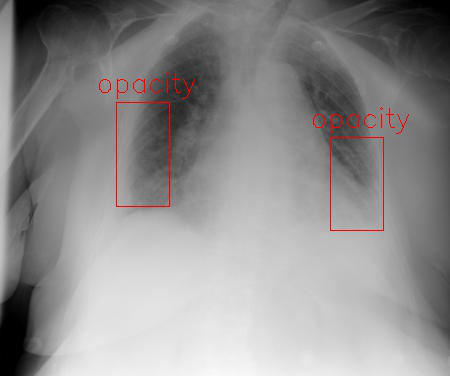

In [20]:
# bucle para cargar todos los recuadros
for box in range(len(df_boxes)):
    # cargamos la imagen
    ex_img_jpg_red = cv2.imread(ex_img_jpg_red_full_dir)   
    
    # cargamos las coordenadas de la esquina inferior izquierda del recuadro
    x1 = int(df_boxes.loc[df_boxes["image_name_jpg"] == ex_img_jpg_file, 'x'][box] * img_jpg_scale)
    y1 = int(df_boxes.loc[df_boxes["image_name_jpg"] == ex_img_jpg_file, 'y'][box] * img_jpg_scale)
    
    # cargamos dimensiones del recuadro
    w = int((df_boxes.loc[df_boxes["image_name_jpg"] == ex_img_jpg_file, 'width'][box]) * img_jpg_scale)
    h = int((df_boxes.loc[df_boxes["image_name_jpg"] == ex_img_jpg_file, 'height'][box]) * img_jpg_scale)

    # dibujamos un rectangulo
    ex_img_jpg_red = cv2.rectangle(img = ex_img_jpg_red, pt1 = (x1, y1), pt2 = (x1+w, y1+h), color = (0, 0, 255), thickness = 1)
    print("x,y,w,h:",x1,y1,w,h)
    
    # texto a incluir
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (x1-20,y1-10)
    fontScale              = 0.9
    fontColor              = (0,0,255)
    lineType               = 1
    ex_img_jpg_red_text = df_boxes.loc[df_boxes["image_name_jpg"] == ex_img_jpg_file, 'label_diagnostic'][box]

    cv2.putText(ex_img_jpg_red, ex_img_jpg_red_text, bottomLeftCornerOfText, font, fontScale, fontColor, lineType)

    # gueardamos la imagen
    cv2.imwrite(ex_img_jpg_red_full_dir, ex_img_jpg_red)
    
# mostramos la imagen jpg
ex_img_jpg_red = load_img(ex_img_jpg_red_full_dir)
ex_img_jpg_red

# Conversion de datos masivos `dcm` a `jpg`

## `dcm` en `train` a `jpg` en `train_jpg`

A continuacion crearemos una carpeta `train_jpg` para almacenar los datos de entrenamiento. Luego utilizamos un bucle para convertir cada imagenes `DCM` del dataframe de entrenamiento `X_train` desde la carpeta `train` a una imagen `JPG` en la carpeta de destino.

In [25]:
# definimos carpeta de destino `train_jpg`
train_jpg_folder_path = "./data/train_jpg/"
if not os.path.exists(train_jpg_folder_path):
    os.makedirs(train_jpg_folder_path)

# creacion de contadores
count_total = 0 # count total number of files
count_new = 0 # count of new files
# bucle para covertir archivos
for row_index, image_name in df_train[['image_name_jpg']].iterrows(): # row_index: observation index, image_name: observation image name
    is_image_name_aux = df_train['image_name_jpg']==image_name[0] # is_image_name: image_name without extension
    dcm_full_dir_aux = df_train[is_image_name_aux]['full_dir'].item() # directory of original DCM file
    jpg_full_dir_aux = train_jpg_folder_path+df_train[is_image_name_aux]['image_name_jpg'].item() # directory of output JPG file
    count_total += 1
    if not os.path.exists(jpg_full_dir_aux): # Actions if JPG file does not exist
        count_new += 1
        ds_aux = dicom.dcmread(dcm_full_dir_aux) # read DCM file
        pixel_array_numpy_aux = ds_aux.pixel_array # calculate pixel array
        scaled_img_aux = cv2.convertScaleAbs(pixel_array_numpy_aux-np.min(pixel_array_numpy_aux), alpha=(255.0 / min(np.max(pixel_array_numpy_aux)-np.min(pixel_array_numpy_aux), 10000))) # scaling of image
        cv2.imwrite(jpg_full_dir_aux, scaled_img_aux) # save new scaled JPG file

# muestra resultados
print('JPG train folder has {} images.'.format(count_total))
print('{} images were created.'.format(count_new))

JPG train folder has 6334 images.
280 images were created.


# Modelo

## Argumentos del Image Data Generator

In [34]:
# pandas dataframe
dataframe = df_train[['image_name_jpg','diagnostic_cat']].copy()

# directorio que contine la imágenes
directory = train_jpg_folder_path

# columna del dataframe que contiene el nombre de las imágenes
x_col = 'image_name_jpg'

# columna del dataframe que contiene la clasificación de las imágenes
y_col = 'diagnostic_cat'

# tramaño final de imágenes a reducir por el Image Data Generator
n_max_pixel = 150

# colores finales de las imágenes a reducir por el Image Data Generator
color_mode = 'grayscale'

# tamaño de batches de data
batch_size = 32

# reescalado de imágenes a reducir por el Image Data Generator 
rescale=1./255

# train/validation split de imágenes a reducir por el Image Data Generator
validation_split=0.25

## Creacion del Image Data Generator

In [40]:
# creacion del Image Data Generator genérico
data_generator = ImageDataGenerator(rescale = rescale,
                                    validation_split = validation_split)

# creacion del Image Data Generator para datos de training
train_generator = data_generator.flow_from_dataframe(dataframe = dataframe,
                                                     directory = directory, 
                                                     x_col =  x_col,
                                                     y_col = y_col,
                                                     subset = 'training',
                                                     batch_size = batch_size,
                                                     seed = 123,
                                                     shuffle = True,
                                                     class_mode = 'categorical',
                                                     target_size = (n_max_pixel, n_max_pixel), 
                                                     color_mode = color_mode
                                                     )
# creacion del Image Data Generator para datos de training
val_generator = data_generator.flow_from_dataframe(dataframe = dataframe,
                                                     directory = directory, 
                                                     x_col =  x_col,
                                                     y_col = y_col,
                                                     subset = 'validation',
                                                     batch_size = batch_size,
                                                     seed = 123,
                                                     shuffle = True,
                                                     class_mode = 'categorical',
                                                     target_size = (n_max_pixel, n_max_pixel), 
                                                     color_mode = color_mode
                                                     )

Found 4751 validated image filenames belonging to 4 classes.
Found 1583 validated image filenames belonging to 4 classes.


## Creación del modelo